### 건설업

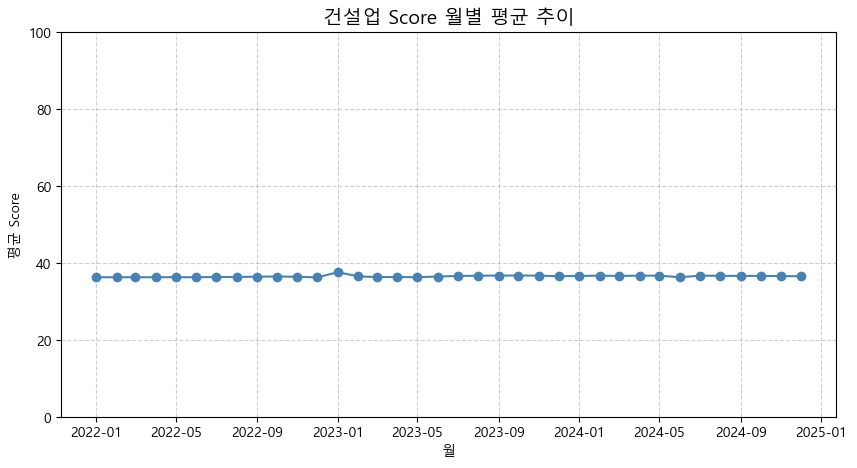

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '건설업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {'법인_고객등급':0.6,'전담고객여부':0.6,'예금잔액':1.2,'투자잔액':0.5,
         '여신대출잔액':1.2,'예금비중':1.2,'대출비중':-0.8,'여신_신용카드_좌수':0.8,
         '거래금액':0.8,'거래건수':0.8}
lam = 0.65

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 건설업 Score 계산
# ================================================================
target_industry = "건설업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 건설업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 교육 서비스업

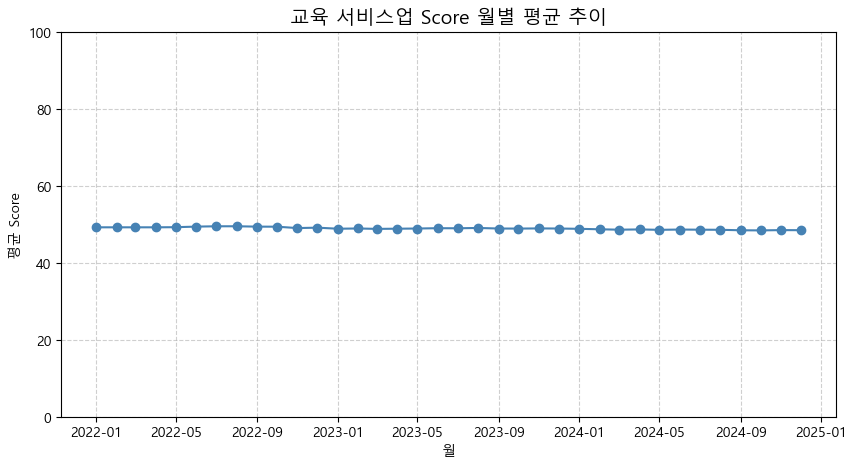

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '교육 서비스업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 0.6,
            '예금잔액': 1.0, '투자잔액': 1.0, '여신대출잔액': 1.2,
            '예금비중': 0.8, '대출비중': -1.2,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.8, '거래건수': 0.8}
lam = 0.7

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 교육 서비스업 Score 계산
# ================================================================
target_industry = "교육 서비스업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 교육 서비스업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 농업, 임업 및 어업

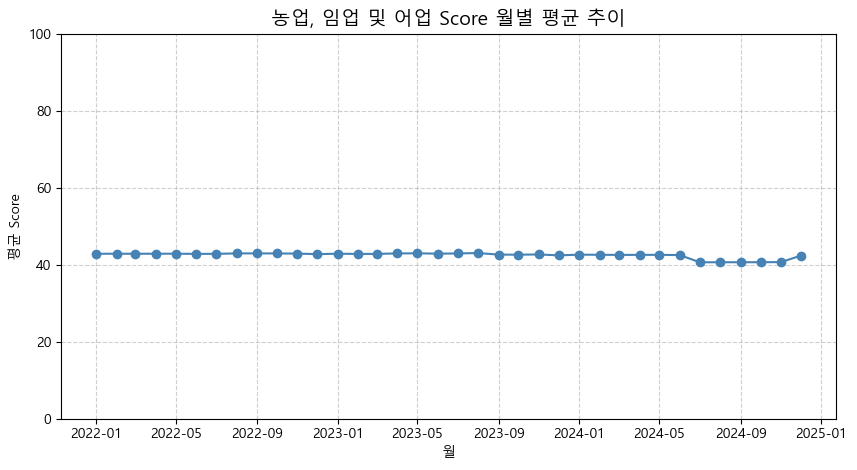

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '농업, 임업 및 어업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {    '법인_고객등급': 0.6, '전담고객여부': 0.6,
            '예금잔액': 1.0, '투자잔액': 1.0, '여신대출잔액': 1.2,
            '예금비중': 0.8, '대출비중': -1.2,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.8, '거래건수': 0.8}
lam = 0.45

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 건설업 Score 계산
# ================================================================
target_industry = "농업, 임업 및 어업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 건설업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 수도, 하수 및 폐기물 처리, 원료 재생업

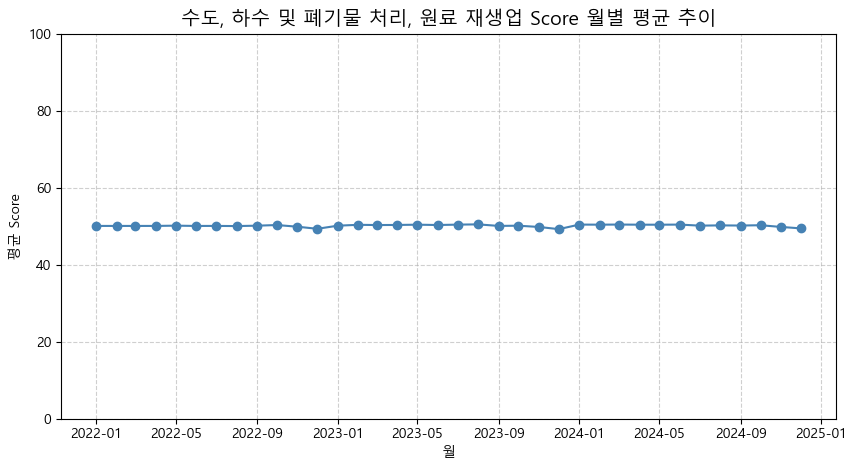

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '수도, 하수 및 폐기물 처리, 원료 재생업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 0.6,
            '예금잔액': 1.0, '투자잔액': 0.6, '여신대출잔액': 1.2,
            '예금비중': 0.9, '대출비중': -1.2,
            '여신_신용카드_좌수': 1.0, '거래금액': 1.0, '거래건수': 1.0}
lam = 0.6

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 수도, 하수 및 폐기물 처리, 원료 재생업 Score 계산
# ================================================================
target_industry = "수도, 하수 및 폐기물 처리, 원료 재생업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 수도, 하수 및 폐기물 처리, 원료 재생업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 전기, 가스, 증기 및 공기조절 공급업

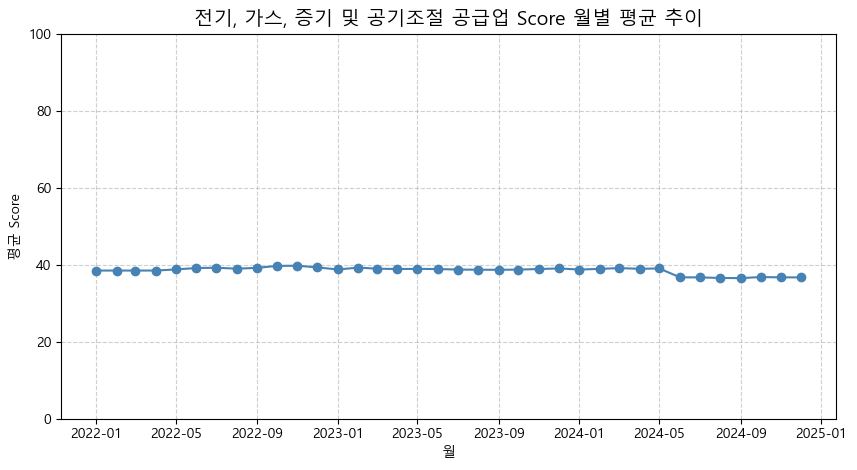

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '전기, 가스, 증기 및 공기조절 공급업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 1.2,
            '예금잔액': 1.2, '투자잔액': 0.5, '여신대출잔액': 1.2,
            '예금비중': 0.8, '대출비중': -0.7,
            '여신_신용카드_좌수': 1.2, '거래금액': 1.2, '거래건수': 1.2}
lam = 0.75

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 전기, 가스, 증기 및 공기조절 공급업 Score 계산
# ================================================================
target_industry = "전기, 가스, 증기 및 공기조절 공급업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 전기, 가스, 증기 및 공기조절 공급업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 전문, 과학 및 기술 서비스업

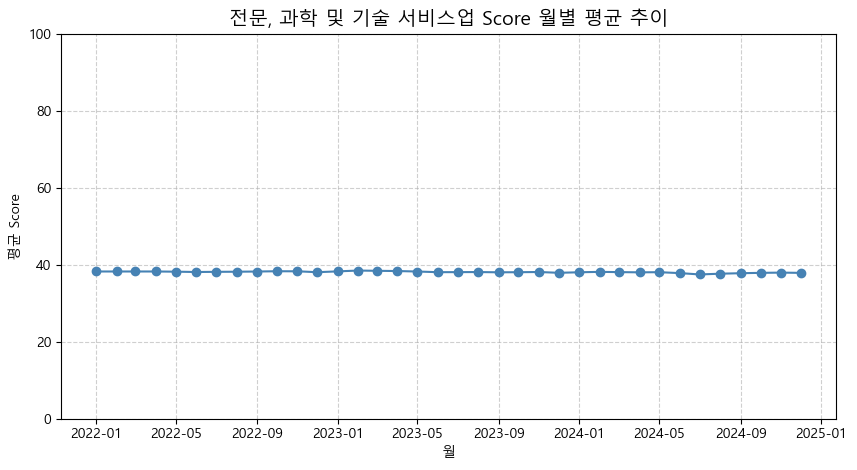

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '전문, 과학 및 기술 서비스업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 0.6,
            '예금잔액': 0.8, '투자잔액': 0.6, '여신대출잔액': 1.2,
            '예금비중': 0.8, '대출비중': -1.2,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.8, '거래건수': 0.8}
lam = 0.5

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 전문, 과학 및 기술 서비스업 Score 계산
# ================================================================
target_industry = "전문, 과학 및 기술 서비스업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 전문, 과학 및 기술 서비스업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 정보통신업

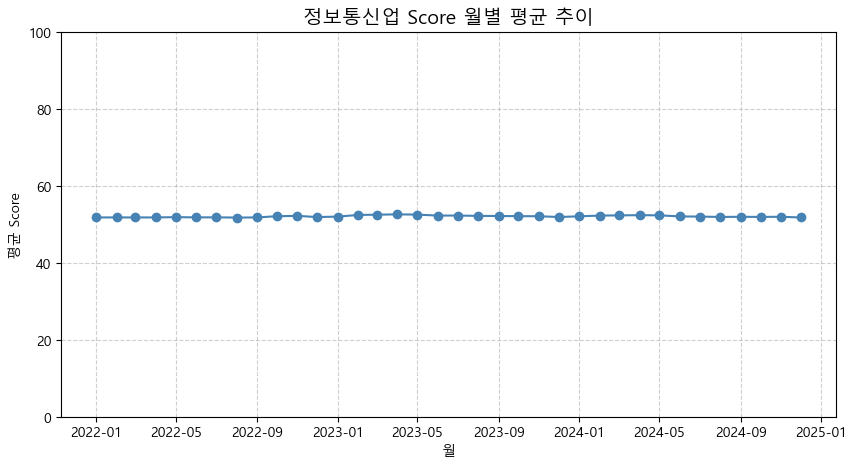

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '정보통신업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 1.2,
            '예금잔액': 1.0, '투자잔액': 0.5, '여신대출잔액': 1.2,
            '예금비중': 1.2, '대출비중': -1.2,
            '여신_신용카드_좌수': 1.2, '거래금액': 0.8, '거래건수': 1.2}
lam = 0.75

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 정보통신업 Score 계산
# ================================================================
target_industry = "정보통신업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 정보통신업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 도매 및 소매업

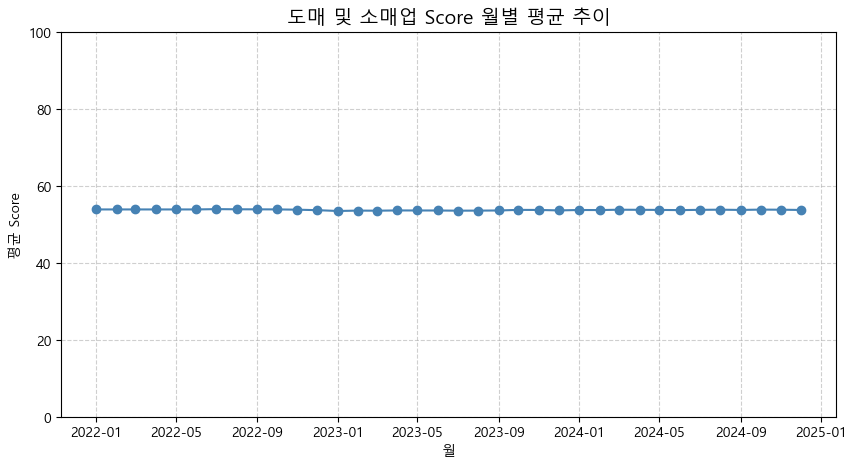

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '도매 및 소매업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 0.8,
            '예금잔액': 1.4, '투자잔액': 1.4, '여신대출잔액': 1.8,
            '예금비중': 1.2, '대출비중': -0.6,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.8, '거래건수': 0.99}
lam = 0.6

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9) 도매 및 소매업 Score 계산
# ================================================================
target_industry = "도매 및 소매업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 도매 및 소매업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 부동산업

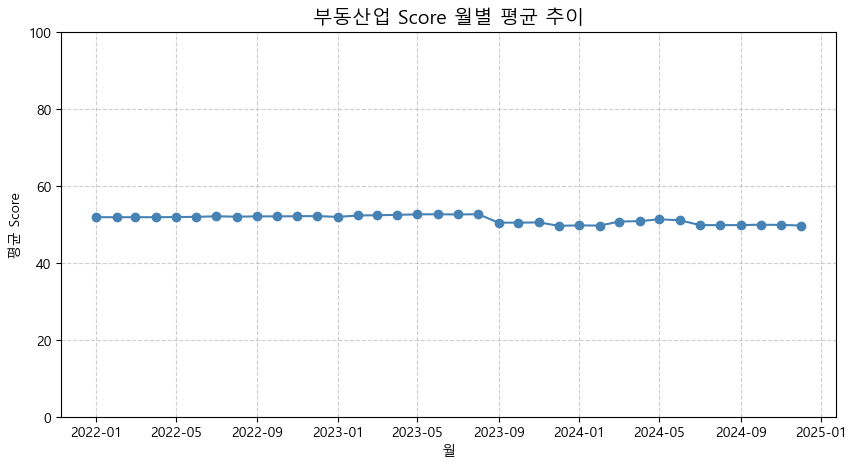

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '부동산업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {    '법인_고객등급': 0.8, '전담고객여부': 0.8,
            '예금잔액': 1.0, '투자잔액': 1.0, '여신대출잔액': 1.2,
            '예금비중': 1.2, '대출비중': -1.2,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.99, '거래건수': 0.99}
lam = 0.6

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9)  부동산업 Score 계산
# ================================================================
target_industry = "부동산업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 부동산업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### 사업시설 관리, 사업 지원 및 임대 서비스업

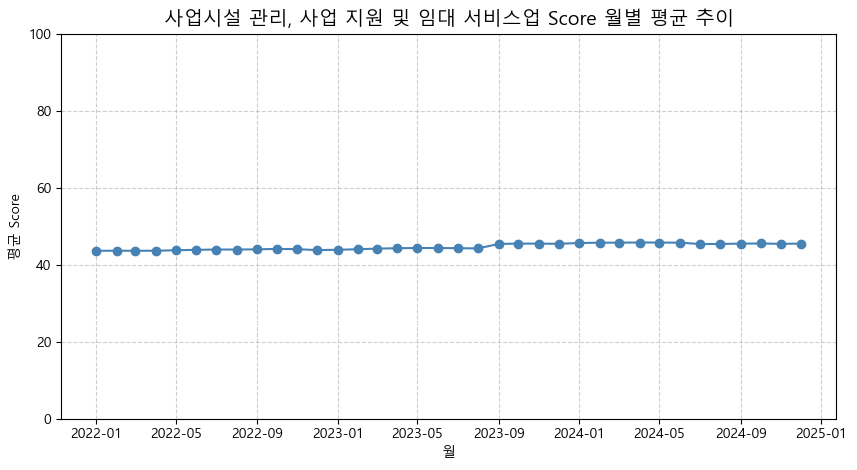

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

# ================================================================
# 0) 데이터 로드
# ================================================================
df = pd.read_csv(r'C:\imbankproj\TEAMPROJ_1\(아이엠뱅크) 2025 교육용 데이터.csv',
                 encoding='cp949')

rating = pd.read_csv("기업신용등급 분포.csv", encoding='cp949')

# ================================================================
# 1) 거래채널별 거래건수/좌수 전처리
# ================================================================
import re
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(x: float) -> int:
    return int(Decimal(str(x)).quantize(Decimal('1'), rounding=ROUND_HALF_UP))

def conv_count_strict(value, open_end_add: int = 5, return_int: bool = True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    s = str(value).strip()
    s = re.sub(r'\s+', '', s).replace('，', ',')
    m = re.fullmatch(r'^(\d+)(개|건)$', s)
    if m:
        out = float(m.group(1))
    else:
        m = re.fullmatch(r'^(\d+)(개|건)초과(\d+)(개|건)이하$', s)
        if m:
            a, b = int(m.group(1)), int(m.group(3))
            mid = (a + b) / 2.0
            out = round_half_up(mid) if return_int else mid
        else:
            m = re.fullmatch(r'^(\d+)(개|건)초과$', s)
            if m:
                a = int(m.group(1))
                out = a + int(open_end_add)
            else:
                return np.nan
    return int(out) if return_int else float(out)

columns1 = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수','수익증권좌수','신탁좌수','퇴직연금좌수',
    '여신_운전자금대출좌수','여신_시설자금대출좌수','신용카드개수'
]
columns2 = [
    '외환_수출실적거래건수','외환_수입실적거래건수','창구거래건수','인터넷뱅킹거래건수',
    '스마트뱅킹거래건수','폰뱅킹거래건수','ATM거래건수','자동이체거래건수'
]
for col in columns1 + columns2:
    df[col] = df[col].apply(lambda v: conv_count_strict(v, open_end_add=5, return_int=True))

# ================================================================
# 2) 파생 칼럼
# ================================================================
df['예금잔액'] = df.iloc[:, 7:10].sum(axis=1)
df['투자잔액'] = df.iloc[:, 10:13].sum(axis=1)
df['예금_투자_잔액'] = df['예금잔액'] + df['투자잔액']
df['여신대출잔액'] = df.iloc[:, 14:16].sum(axis=1)

den = df['예금잔액'] + df['투자잔액'] + df['여신대출잔액']
df['예금비중'] = df['예금잔액'] / den
df['대출비중'] = df['여신대출잔액'] / den

df['외환실적'] = df.iloc[:, 16:18].sum(axis=1)
df['여신_신용카드_좌수'] = df.loc[:, '여신_운전자금대출좌수':'신용카드개수'].sum(axis=1)
df['온라인_거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수','폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)
df['오프라인_거래건수'] = df[['창구거래건수','ATM거래건수']].sum(axis=1)
df['거래건수'] = df['온라인_거래건수'] + df['오프라인_거래건수']
df['거래금액'] = df.loc[:, '신용카드사용금액':'요구불출금금액'].sum(axis=1)

# ================================================================
# 3) 업종별 DataFrame
# ================================================================
df_est = df[df['업종_대분류'] == '사업시설 관리, 사업 지원 및 임대 서비스업']

# ================================================================
# 4) 등급/전담 숫자화
# ================================================================
def ensure_numeric_grade_and_ded(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    if out['법인_고객등급'].dtype == 'object':
        out['법인_고객등급'] = out['법인_고객등급'].astype(str).str.strip().map({'일반':1,'우수':2,'최우수':3})
    if out['전담고객여부'].dtype == 'object':
        out['전담고객여부'] = out['전담고객여부'].astype(str).str.strip().str.upper().map({'Y':1,'N':0})
    return out

# ================================================================
# 5) 스케일러
# ================================================================
def fit_linear_scaler(X: pd.DataFrame, method='minmax', q_low=0.01, q_high=0.99):
    params = {}
    for c in X.columns:
        x = pd.to_numeric(X[c], errors='coerce')
        if method=='minmax':
            lo, hi = np.nanmin(x), np.nanmax(x)
        elif method=='winsor_minmax':
            lo, hi = x.quantile(q_low), x.quantile(q_high)
        else:
            raise ValueError("method must be 'minmax' or 'winsor_minmax'")
        if not np.isfinite(lo) or not np.isfinite(hi) or hi==lo:
            lo, hi = 0.0, 1.0
        params[c] = (float(lo), float(hi))
    params['_method'] = method
    params['_q'] = (q_low, q_high)
    return params

def transform_linear_scaler(X: pd.DataFrame, params: dict):
    A = pd.DataFrame(index=X.index, columns=X.columns, dtype=float)
    for c in X.columns:
        lo, hi = params[c]
        x = pd.to_numeric(X[c], errors='coerce').astype(float)
        a = (x - lo)/(hi-lo) if hi>lo else pd.Series(0.0,index=X.index)
        A[c] = a.clip(0,1)
    return A

# ================================================================
# 6) 스코어 계산
# ================================================================
def score_linear_preserve_shape(df_est, feature_cols, weights, lam, beta=1.0,
                                scaler_method='minmax', q_low=0.01, q_high=0.99,
                                l1_normalize=True, rescale_0_100=True):
    df_num = ensure_numeric_grade_and_ded(df_est)
    X_raw = df_num[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    rho = (X_raw==0).sum(axis=0)/len(X_raw)
    scaler_params = fit_linear_scaler(X_raw, method=scaler_method, q_low=q_low, q_high=q_high)
    A = transform_linear_scaler(X_raw, scaler_params)
    w = pd.Series({c:float(weights.get(c,0.0)) for c in feature_cols}, dtype=float)
    if l1_normalize:
        denom = w.abs().sum()
        if denom>0:
            w = w/denom
    pos = A.mul(w,axis=1).sum(axis=1)
    pen = (A.mul(rho,axis=1)).sum(axis=1)*lam
    S_raw = pos - pen
    if rescale_0_100 and (S_raw.max() > S_raw.min()):
        S_scaled = 100*(S_raw - S_raw.min())/(S_raw.max() - S_raw.min())
    else:
        S_scaled = S_raw
    S_final = beta*S_scaled
    S_final = np.clip(S_final,0,100)
    out = df_est.copy()
    out['score'] = S_final.round(2)
    report = {"weights(L1={})".format('1' if l1_normalize else 'raw'): w.to_dict(),
              "lambda": lam, "beta": beta, "rho_zero_ratio": rho.to_dict(),
              "scaler": scaler_method, "quantiles": (q_low,q_high)}
    return out, report

# ================================================================
# 7) 파라미터
# ================================================================
feature_cols = [
    '법인_고객등급','전담고객여부','예금잔액','투자잔액','여신대출잔액',
    '예금비중','대출비중','여신_신용카드_좌수','거래건수','거래금액'
]
omega = {   '법인_고객등급': 0.6, '전담고객여부': 1.4,
            '예금잔액': 1.0, '투자잔액': 1.2, '여신대출잔액': 1.2,
            '예금비중': 0.8, '대출비중' : -1.0,
            '여신_신용카드_좌수': 0.8, '거래금액': 0.8, '거래건수': 0.8}
lam = 0.5

# ================================================================
# 8) Beta_Industry_final.csv 읽기 + 1~3월 4월값으로 대체
# ================================================================
beta_df = pd.read_csv(r"C:\imbankproj\TEAMPROJ_1\Beta_Industry_final.csv", encoding="cp949")
beta_df['월'] = pd.to_datetime(beta_df['월'], format="%Y%m")

# df에 월 컬럼이 없으면 임시 생성 (1월부터 마지막까지)
# 여기서는 df가 연속 월 데이터라고 가정하고 1~3월까지 4월 값 사용
first_beta_row = beta_df.iloc[0].copy()  # 4월
# 1~3월 생성
pre_months = pd.date_range(start=pd.Timestamp(first_beta_row['월'].year, 1, 1),
                           end=first_beta_row['월'] - pd.offsets.MonthBegin(1),
                           freq='MS')
pre_beta_df = pd.DataFrame([first_beta_row.values]*len(pre_months), columns=beta_df.columns)
pre_beta_df['월'] = pre_months
# 합치기
beta_df = pd.concat([pre_beta_df, beta_df], ignore_index=True)
beta_df = beta_df.sort_values('월').reset_index(drop=True)

# ================================================================
# 9)  사업시설 관리, 사업 지원 및 임대 서비스업 Score 계산
# ================================================================
target_industry = "사업시설 관리, 사업 지원 및 임대 서비스업"
all_scores = []

for _, row in beta_df.iterrows():
    month = row['월']
    beta_val = row[target_industry]
    df_ind = df[df['업종_대분류']==target_industry].copy()
    if df_ind.empty:
        continue
    scored, rpt = score_linear_preserve_shape(
        df_ind, feature_cols, weights=omega, lam=lam, beta=beta_val,
        scaler_method='minmax', l1_normalize=True, rescale_0_100=True
    )
    scored['score'] = np.clip(scored['score'],0,100)
    scored['월'] = month
    all_scores.append(scored[['월','score']])

all_scores_df = pd.concat(all_scores)

# ================================================================
# 10) 사업시설 관리, 사업 지원 및 임대 서비스업 Score 월별 평균 추이 (라인 그래프)
# ================================================================
mean_scores = all_scores_df.groupby("월")["score"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(mean_scores["월"], mean_scores["score"], marker="o", linestyle="-", color="steelblue")
plt.title(f"{target_industry} Score 월별 평균 추이", fontsize=14)
plt.xlabel("월")
plt.ylabel("평균 Score")
plt.ylim(0,100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
